# Vorlesung: Das Traveling Salesman Problem

---

## Lernziele der heutigen Sitzung:

- Verständnis des Traveling Salesman Problems als klassisches NP-schweres Optimierungsproblem
- Kennenlernen verschiedener Algorithmen zur exakten und approximativen Lösung
- Implementierung und Analyse der Algorithmen in Python
- Vergleich der Algorithmen hinsichtlich Laufzeit und Approximationsgüte

---

## 1. Einführung in das Problem

Das **Traveling Salesman Problem (TSP)** ist ein klassisches Problem der Informatik und Optimierung. Es modelliert folgende Situation:

Ein Reisender soll mehrere Punkte besuchen. Er möchte dabei:
- Jeden Punkt genau einmal besuchen
- Am Ende zu seinem Ausgangspunkt zurückkehren
- Die zurückgelegte Gesamtstrecke minimieren

**Anwendungsbeispiele:**
- Tourenplanung für Lieferfahrzeuge
- Optimierung von Wartungsrouten
- Leiterplattenherstellung (optimale Anordnung von Bohrungen)
- Genomsequenzierung

In dieser Vorlesung untersuchen wir drei algorithmische Ansätze:

1. **Brute-Force-Algorithmus**: Probiert alle möglichen Routen aus (optimal, aber sehr langsam)
2. **Nearest-Neighbor-Algorithmus**: Eine einfache Greedy-Strategie, die immer zum nächstgelegenen Punkt geht
3. **Christofides-Algorithmus**: Ein fortgeschrittenes Approximationsverfahren mit garantierter Qualität

Wir werden für jeden dieser Algorithmen analysieren:
- Die theoretischen Grundlagen
- Die praktische Implementierung
- Die Laufzeitkomplexität
- Die Qualität der Lösung

---

## 2. Mathematische Formulierung

Das Traveling Salesman Problem lässt sich mathematisch wie folgt formalisieren:

Sei $G = (V, E)$ ein vollständiger Graph mit:
- $V = \{1, 2, ..., n\}$ ist die Menge der Knoten (Punkte)
- $E = \{(i, j) | i, j \in V, i \neq j\}$ ist die Menge der Kanten (Verbindungen zwischen Punkten)
- $c: E \rightarrow \mathbb{R}^+$ ist eine Kostenfunktion, die jeder Kante $(i, j) \in E$ ein Gewicht $c_{ij}$ zuordnet (die Entfernung zwischen Punkt $i$ und Punkt $j$)

**Ziel:** Finde einen Hamiltonkreis mit minimalen Gesamtkosten. Ein Hamiltonkreis ist ein geschlossener Pfad, der jeden Knoten genau einmal besucht und zum Ausgangspunkt zurückkehrt.

**Mathematische Formulierung:** Gesucht ist eine Permutation $\pi$ von $\{1, 2, ..., n\}$, die die folgende Kostenfunktion minimiert:

$$ \sum_{i=1}^{n-1} c_{\pi(i),\pi(i+1)} + c_{\pi(n),\pi(1)} $$

**Komplexitätsklasse:** Das TSP ist NP-schwer. Dies bedeutet, dass kein effizienter (polynomieller) Algorithmus bekannt ist, der optimale Lösungen für beliebig große Instanzen garantiert.

**Konsequenz für die Praxis:** Bei $n$ Punkten gibt es $(n-1)!/2$ verschiedene mögliche Routen. Bei 10 Punkten sind dies bereits über 180.000 Routen, bei 15 Punkten über 43 Milliarden.

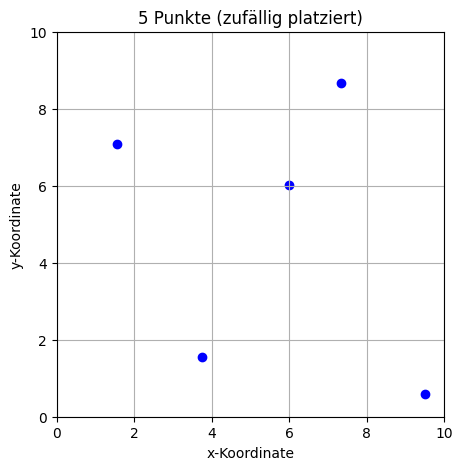

In [60]:
# Vorbereitung: Notwendige Bibliotheken importieren und Testdaten generieren

import numpy as np
import matplotlib.pyplot as plt
import math
import time  # Für Zeitmessungen der Algorithmen

# Hilfsfunktion zum Visualisieren der Punktemenge
def plot():
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, color='blue')  # Punkte als Scatterplot darstellen
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.grid(True)
    plt.title(f'{number_of_points} Punkte (zufällig platziert)')
    plt.xlabel('x-Koordinate')
    plt.ylabel('y-Koordinate')
    plt.show()

# Für die Reproduzierbarkeit der Vorlesung: Feste Zufallszahlen
number_of_points = 5  # Anzahl der Punkte
np.random.seed(42)    # Für reproduzierbare Ergebnisse

# Generiere zufällige Koordinaten im Bereich [0, 10] × [0, 10]
x = np.random.rand(number_of_points) * 10  # x-Koordinaten
y = np.random.rand(number_of_points) * 10  # y-Koordinaten

# Erstelle Liste von Punkten als (x,y)-Koordinatenpaare
points = list(zip(x, y))

# Dictionary für spätere Ergebnisauswertung vorbereiten
algorithm_results = {
    'brute_force': {'distance': None, 'time': None, 'operations': None},
    'nearest_neighbor': {'distance': None, 'time': None, 'operations': None},
    'christofides': {'distance': None, 'time': None, 'operations': None}
}

# Visualisiere die generierten Punkte
plot()

---

## 3. Exakte Lösung: Brute-Force-Algorithmus

Der einfachste Ansatz zur Lösung des TSP ist die vollständige Aufzählung aller möglichen Routen, auch als Brute-Force-Ansatz bekannt.

### 3.1 Grundprinzip

1. Generiere systematisch alle möglichen Rundwege (Permutationen der Punkte)
2. Berechne für jeden Rundweg die Gesamtlänge
3. Wähle den kürzesten Rundweg

### 3.2 Mathematische Analyse

**Anzahl möglicher Rundwege:** Bei $n$ Punkten gibt es $(n-1)!$ verschiedene Rundwege (der erste Punkt kann festgelegt werden, danach müssen die restlichen $n-1$ Punkte permutiert werden).

**Korrektheit:** Der Algorithmus findet garantiert das globale Optimum, da er alle möglichen Lösungen prüft.

**Zeitkomplexität:** $O(n!)$ - faktoriell in der Anzahl der Punkte.
 - Bei $n=10$ Punkten: ca. 3,6 Millionen Permutationen
 - Bei $n=15$ Punkten: ca. 87 Milliarden Permutationen
 - Bei $n=20$ Punkten: ca. $10^{18}$ Permutationen

**Speicherkomplexität:** $O(n)$ - linear, da wir jeweils nur eine Permutation im Speicher halten müssen.

### 3.3 Implementierungsdetails

Wir verwenden das `permutations`-Modul aus `itertools` zur effizienten Generierung aller Permutationen:

In [61]:
from itertools import permutations
import math

# Vereinfachte Distanzfunktion unter Verwendung von math.dist.
def route_distance(route):
    # Für eine gegebene Route berechnen wir die Gesamtdistanz,
    # indem wir die Distanzen zwischen jedem aufeinanderfolgenden Punktpaar aufsummieren.
    # Dabei wird math.dist() verwendet, um die euklidische Distanz zwischen zwei Punkten zu berechnen.
    d = sum(math.dist(route[i], route[i+1]) for i in range(len(route)-1))
    
    # Abschließend wird die Distanz vom letzten Punkt zurück zum Startpunkt addiert,
    # um den Rundweg zu schließen.
    return d + math.dist(route[-1], route[0])

In [62]:
def plot_brute_force():
    # Erstelle eine Grafik und plotte die Punkte
    plt.clf()  # Aktuelle Grafik löschen

    # Extrahiere die x- und y-Koordinaten aller Punkte und plote sie als blauen Scatterplot.
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=3)

    # Erstelle Listen für die x- und y-Koordinaten der Route.
    # Schließe die Route, indem du den Startpunkt am Ende wieder hinzufügst.
    xs = [p[0] for p in best_route_local] + [best_route_local[0][0]]
    ys = [p[1] for p in best_route_local] + [best_route_local[0][1]]
    # Verbinde die Punkte der Route mit einer roten Linie und markiere jeden Punkt.
    plt.plot(xs, ys, color='red', linewidth=2, marker='o')

    # Füge einen Titel hinzu, der die Gesamtdistanz der Route anzeigt.
    plt.title(f"Brute Force Distance: {best_distance:.2f}")

    # Entferne die Achsenbeschriftungen.
    plt.xticks([])
    plt.yticks([])

    fig = plt.gcf()
    fig.set_size_inches(fig.get_size_inches() * 0.5)
    plt.savefig("brute_force.png", dpi=300, format="png", bbox_inches="tight")
    plt.show()

In [63]:
operation_count_bf = 0  # Zähler für Operationen (hier: Berechnungen von Strecken)
start_time_bf = time.time()  # Startzeit messen

best_distance = math.inf # Initialisiere best_distance mit unendlich, sodass jede berechnete Route kürzer ist.
best_route_local = None

# Suche die beste Route, indem alle Permutationen geprüft werden | https://docs.python.org/3/library/itertools.html 
for route in permutations(points): # r-Länge, alle möglichen Permutationen ohne wiederholte Elemente
    operation_count_bf += 1
    d_current = route_distance(route)
    if d_current < best_distance:
        best_distance = d_current
        best_route_local = route
# FRAGE : Wie ist die Laufzeit dieser Funktion? | O(n!) https://de.wikipedia.org/wiki/Fakult%C3%A4t_(Mathematik)

end_time_bf = time.time()  # Endzeit messen
execution_time_bf = end_time_bf - start_time_bf  # Berechnungszeit in Sekunden

# Speichere Ergebnisse
algorithm_results['brute_force']['distance'] = best_distance
algorithm_results['brute_force']['time'] = execution_time_bf
algorithm_results['brute_force']['operations'] = operation_count_bf

print(f"Beste gefundene Route-Länge: {best_distance:.2f}")
print(f"Berechnungszeit: {execution_time_bf:.6f} Sekunden")
print(f"Anzahl der überprüften Routen: {operation_count_bf}")

Beste gefundene Route-Länge: 27.19
Berechnungszeit: 0.000000 Sekunden
Anzahl der überprüften Routen: 120


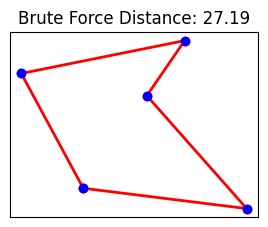

In [64]:
# Visualisiere die gefundene Route
plot_brute_force()

---

## 3.4 Brute-Force-Algorithmus mit festem Startpunkt

In der obigen Implementierung des Brute-Force-Algorithmus werden alle möglichen Permutationen sämtlicher Punkte betrachtet. Bei $n$ Punkten gibt es $n!$ solcher Permutationen. 

In vielen praktischen Anwendungen ist jedoch der Startpunkt vorgegeben - etwa wenn ein Reisender immer von seinem Heimatpunkt aus starten und dorthin zurückkehren muss. In diesem Fall reduziert sich die Anzahl der zu betrachtenden Permutationen auf $(n-1)!$, da nur noch die Reihenfolge der anderen Punkte variiert wird.

### Vorteile eines festen Startpunkts:

1. **Reduzierte Berechnungskomplexität**: Statt $n!$ müssen nur $(n-1)!$ Permutationen überprüft werden
2. **Realistische Modellierung**: In vielen praktischen Anwendungsfällen ist der Startpunkt tatsächlich fest
3. **Vereinfachte Problemstellung**: Die Problemgröße wird um einen Faktor $n$ reduziert

### Mathematische Auswirkung:

Bei 10 Punkten mit variablem Startpunkt: $10! = 3.628.800$ Permutationen  
Bei 10 Punkten mit festem Startpunkt: $9! = 362.880$ Permutationen

Die Berechnung wird also um den Faktor 10 schneller, was bei größeren Problemen einen erheblichen Unterschied macht.

In [65]:
def brute_force_fixed_start(points, start_index=0):
    """Berechnet die optimale Route mittels Brute-Force mit festem Startpunkt.
    
    Parameter:
      points (list): Liste von (x,y)-Koordinatenpaaren der Punkte
      start_index (int): Index des Startpunkts in der Liste 'points'
    
    Rückgabe:
      tuple: (beste Route, Distanz der besten Route, Anzahl überprüfter Routen)
    """
    operation_count = 0  # Zähler für die Anzahl überprüfter Routen
    start_time = time.time()
    
    # Extrahiere den Startpunkt
    start_point = points[start_index]
    
    # Erstelle eine Liste der zu permutierenden Punkte (alle außer dem Startpunkt)
    other_points = points.copy()
    other_points.pop(start_index)
    
    best_distance = float('inf')
    best_route = None
    
    # Generiere alle Permutationen der übrigen Punkte
    for perm in permutations(other_points):
        # Erstelle vollständige Route mit Startpunkt am Anfang
        route = (start_point,) + perm
        operation_count += 1
        
        # Berechne die Gesamtdistanz dieser Route
        current_distance = route_distance(route)
        
        # Aktualisiere die beste Route, wenn die aktuelle besser ist
        if current_distance < best_distance:
            best_distance = current_distance
            best_route = route
    
    execution_time = time.time() - start_time
    
    return best_route, best_distance, operation_count, execution_time

In [66]:
# # Teste den Brute-Force-Algorithmus mit verschiedenen Startpunkten
# results = {}
# all_routes = []

# # Erzeuge 5 zufällige Punkte für bessere Übersichtlichkeit
# np.random.seed(41)  # Anderer Seed für Variation
# test_points = [(np.random.rand() * 10, np.random.rand() * 10) for _ in range(7)]

# # Visualisiere die Punkte mit Indizes
# plt.figure(figsize=(8, 6))
# for i, (x, y) in enumerate(test_points):
#     plt.scatter(x, y, color='blue', s=100, zorder=5)
#     plt.annotate(f"Punkt {i}", (x, y), xytext=(10, 5), textcoords="offset points", fontsize=12)

# plt.grid(True, alpha=0.3)
# plt.xlim(0, 10)
# plt.ylim(0, 10)
# plt.title("Testpunkte für Brute-Force mit verschiedenen Startpunkten")
# plt.show()

# print("Berechnung der optimalen Routen mit verschiedenen Startpunkten...")
# print("-" * 60)

# # Berechne für jeden möglichen Startpunkt
# for i in range(len(test_points)):
#     route, distance, operations, execution_time = brute_force_fixed_start(test_points, i)
#     results[i] = {
#         "distance": distance,
#         "operations": operations,
#         "time": execution_time
#     }
#     all_routes.append((i, route, distance))
#     print(f"Startpunkt {i}: Distanz = {distance:.2f}, Berechnungszeit = {execution_time:.6f}s, Überprüfte Routen = {operations}")

# # Finde die beste Route über alle Startpunkte
# best_overall = min(all_routes, key=lambda x: x[2])
# print("-" * 60)
# print(f"Beste Route insgesamt beginnt bei Punkt {best_overall[0]} mit Distanz {best_overall[2]:.2f}")



# # Visualisiere die beste Route
# plt.figure(figsize=(8, 6))
# for i, (x, y) in enumerate(test_points):
#     if i == best_overall[0]:
#         plt.scatter(x, y, color='red', s=150, zorder=10, edgecolor='black')
#         plt.annotate(f"Start: {i}", (x, y), xytext=(10, 5), textcoords="offset points", fontsize=12, weight='bold')
#     else:
#         plt.scatter(x, y, color='blue', s=100, zorder=5)
#         plt.annotate(f"{i}", (x, y), xytext=(10, 5), textcoords="offset points", fontsize=12)

# # Zeichne die Route als geschlossenen Pfad
# best_route = best_overall[1]
# route_x = [p[0] for p in best_route] + [best_route[0][0]]
# route_y = [p[1] for p in best_route] + [best_route[0][1]]
# plt.plot(route_x, route_y, 'r-', linewidth=2, zorder=1)

# # Zeige die Reihenfolge der Besuche durch nummerierte Pfeile
# for i in range(len(best_route)-1):
#     plt.annotate("", 
#                 xy=(best_route[i+1][0], best_route[i+1][1]),
#                 xytext=(best_route[i][0], best_route[i][1]),
#                 arrowprops=dict(arrowstyle="->", color='darkred', lw=1.5))
#     midx = (best_route[i][0] + best_route[i+1][0]) / 2
#     midy = (best_route[i][1] + best_route[i+1][1]) / 2
#     plt.text(midx, midy, str(i+1), fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# # Zeichne den Rückweg zum Startpunkt
# plt.annotate("", 
#             xy=(best_route[0][0], best_route[0][1]),
#             xytext=(best_route[-1][0], best_route[-1][1]),
#             arrowprops=dict(arrowstyle="->", color='darkred', lw=1.5))
# midx = (best_route[0][0] + best_route[-1][0]) / 2
# midy = (best_route[0][1] + best_route[-1][1]) / 2
# plt.text(midx, midy, str(len(best_route)), fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# plt.grid(True, alpha=0.3)
# plt.xlim(0, 10)
# plt.ylim(0, 10)
# plt.title(f"Optimale Route mit Start bei Punkt {best_overall[0]} (Distanz: {best_overall[2]:.2f})")
# plt.show()

### Vergleichsanalyse: Variabler vs. fester Startpunkt

Die Ergebnisse zeigen, dass bei festem Startpunkt die optimale Route je nach Wahl des Startpunkts variieren kann. Dies hat wichtige praktische Implikationen:

1. **Vergleich der Recheneffizienz:**
   - Bei $n$ Punkten reduziert sich die Anzahl der zu überprüfenden Routen von $n!$ auf $(n-1)!$
   - Bei 7 Punkten bedeutet das eine Reduktion von 5.040 auf 720 Routen, ein Faktor von 7

2. **Wahl des optimalen Startpunkts:**
   - Wenn der Startpunkt variabel ist und wir den besten Startpunkt wählen könnten, müssten wir dennoch alle $n!$ Permutationen betrachten
   - In manchen Anwendungsfällen ist der Startpunkt jedoch durch praktische Überlegungen festgelegt (z.B. Standort eines Depots)

3. **Theoretische Erkenntnisse:**
   - Die Länge der optimalen Route ist unabhängig davon, in welcher Reihenfolge sie durchlaufen wird (im Uhrzeigersinn oder gegen den Uhrzeigersinn)
   - Die Wahl des Startpunktes beeinflusst jedoch bei manchen Graphenstrukturen die Länge der optimalen Route

Diese Analyse verdeutlicht die Bedeutung der Problemspezifikation beim Traveling Salesman Problem. Die exakte Definition des Problems kann erhebliche Auswirkungen auf die Berechnungskomplexität und die gefundenen Lösungen haben.

---

## Nearest-Neighbor-Algorithmus

Der Nearest-Neighbor-Algorithmus (Nächster-Nachbar-Algorithmus) ist eine einfache Strategie, die auf gesundem Menschenverstand basiert:

1. Beginne an einem beliebigen Startpunkt (einem Punkt)
2. Finde den nächstgelegenen Punkt, der noch nicht besucht wurde
3. Gehe zu diesem Punkt
4. Wiederhole Schritte 2-3, bis alle Punkte besucht wurden
5. Kehre zurück zum Ausgangspunkt, um die Tour abzuschließen

**Alltagsbeispiel**: Stellen Sie sich vor, Sie sammeln Pilze im Wald. Sie könnten intuitiv immer zum nächstgelegenen Pilz gehen, den Sie noch nicht gesammelt haben. Dies entspricht genau der Nearest-Neighbor-Strategie.

**Vorteile**:
- Sehr einfach zu verstehen und zu implementieren
- Deutlich schneller als Brute-Force (funktioniert auch für viele Punkte)
- Liefert oft recht gute (aber nicht optimale) Lösungen

**Nachteile**:
- Kann in bestimmten Fällen sehr schlechte Lösungen liefern
- Die Qualität der Lösung hängt stark vom gewählten Startpunkt ab

### Mathematische Grundlage

Der Nearest-Neighbor-Algorithmus ist eine Greedy-Heuristik mit folgender Vorgehensweise:

1. Starte bei einem beliebigen Knoten $v_0$ als aktuellem Knoten.
2. Finde den nächsten unbesuchten Knoten $v_i$ zum aktuellen Knoten, d.h. minimiere $d(v_{current}, v_i)$ über alle unbesuchten Knoten $v_i$.
3. Füge $v_i$ zur Tour hinzu und setze $v_i$ als aktuellen Knoten.
4. Wiederhole Schritte 2 und 3, bis alle Knoten besucht sind.
5. Kehre zum Startknoten $v_0$ zurück, um den Kreis zu schließen.

Mathematisch ausgedrückt: In jedem Schritt $i$ wählen wir den Knoten $v_i$, sodass:

$$ v_i = \arg\min_{v \in V_{unvisited}} d(v_{current}, v) $$

Die Zeitkomplexität beträgt $O(n^2)$, was deutlich effizienter als die Brute-Force-Methode ist. Allerdings garantiert dieser Algorithmus keine optimale Lösung und kann im schlimmsten Fall eine Tour liefern, die $\Theta(\log n)$ mal länger als die optimale Tour ist.

**Einfach ausgedrückt**: Bei 100 Punkten müssen wir nur etwa 10.000 Vergleiche durchführen, statt 10^158 Routen wie bei Brute-Force. Das ist ein enormer Unterschied!

In [ ]:
from IPython.display import display

def nearest_neighbor(points):
    # Zähler für Operationen
    operations = 0
    
    # Falls keine Punkte vorhanden sind, gebe eine leere Liste zurück.
    if not points:
        return [], operations
    
    route = [points[0]]    # Beginne die Route mit dem ersten Punkt.
    
    remaining_points = points[1:] # Erstelle eine Liste der noch nicht besuchten Punkte (außer dem Startpunkt).
    
    # Solange noch Punkte übrig sind:
    while remaining_points:
        # Der aktuelle Punkt ist immer der letzte in der Route.
        current = route[-1]
        # Finde den nächsten Punkt, der am nächsten zum aktuellen liegt.
        nearest = min(remaining_points, key=lambda p: math.dist(current, p))
        operations += len(remaining_points)  # Zähle Distanzberechnungen
        # Füge diesen Punkt der Route hinzu.
        route.append(nearest)
        # Entferne den neu besuchten Punkt aus der Liste der verbleibenden Punkte.
        remaining_points.remove(nearest)
    
    return route, operations

In [68]:
# Berechne die Route mit dem Nearest-Neighbor-Algorithmus
start_time_nn = time.time()  # Startzeit messen
nn_route, operation_count_nn = nearest_neighbor(points) 
end_time_nn = time.time()  # Endzeit messen
execution_time_nn = end_time_nn - start_time_nn  # Berechnungszeit in Sekunden

# Berechne die Gesamtdistanz der gefundenen Route, inklusive Rückweg zum Startpunkt.
nn_distance = route_distance(nn_route)

# Speichere Ergebnisse
algorithm_results['nearest_neighbor']['distance'] = nn_distance
algorithm_results['nearest_neighbor']['time'] = execution_time_nn
algorithm_results['nearest_neighbor']['operations'] = operation_count_nn

print(f"Nearest-Neighbor Route-Länge: {nn_distance:.2f}")
print(f"Berechnungszeit: {execution_time_nn:.6f} Sekunden")
print(f"Anzahl der Distanzberechnungen: {operation_count_nn}")

Nearest-Neighbor Route-Länge: 30.03
Berechnungszeit: 0.000000 Sekunden
Anzahl der Distanzberechnungen: 10


In [69]:
def plot_nearest_neighbor():
    # Plotten der Nearest-Neighbor-Route:
    plt.clf()  # Aktuelle Grafik löschen
    # Extrahiere die x- und y-Koordinaten aller Punkte und plote sie als blauen Scatterplot.
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=5)

    # Erstelle Listen für die x- und y-Koordinaten der Route.
    # Schließe die Route, indem du den Startpunkt am Ende wieder hinzufügst.
    xs_nn = [p[0] for p in nn_route] + [nn_route[0][0]]
    ys_nn = [p[1] for p in nn_route] + [nn_route[0][1]]
    # Verbinde die Punkte der Route mit einer grünen Linie und markiere jeden Punkt.
    plt.plot(xs_nn, ys_nn, color='green', linewidth=2, marker='o')

    # Füge einen Titel hinzu, der die Gesamtdistanz der Route anzeigt.
    plt.title(f"Nearest Neighbor Distance: {nn_distance:.2f}")

    # Entferne die Achsenbeschriftungen.
    plt.xticks([])
    plt.yticks([])
    plt.savefig("nearest_neighbor.png", dpi=300, format="png", bbox_inches="tight")
    plt.show()


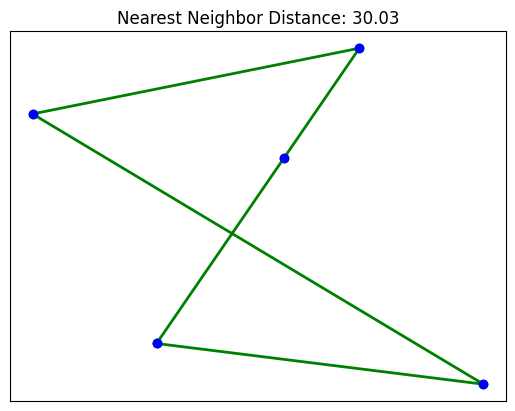

In [70]:
# Visualisiere die gefundene Route
plot_nearest_neighbor()

### Animation des Nearest-Neighbor-Algorithmus

Die folgende Animation zeigt schrittweise, wie der Nearest-Neighbor-Algorithmus funktioniert:

In [71]:
from ipywidgets import Play, IntSlider, jslink, VBox, Output
from IPython.display import display

# Create an output widget for the animation.
out = Output()

play = Play(
    value=0,
    min=0,
    max=len(nn_route),
    step=1,
    interval=500
)

slider = IntSlider(
    value=0,
    min=0,
    max=len(nn_route),
    step=1
)

In [72]:
jslink((play, 'value'), (slider, 'value'))

def animate_nn(i):
    plt.clf()
    # Plot all points as blue scatterplot.
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=5)
    
    # Plot the partial route from the nearest neighbor route.
    if i > 0:
        xs = [p[0] for p in nn_route[:i]]
        ys = [p[1] for p in nn_route[:i]]
        if i == len(nn_route):
            xs.append(nn_route[0][0])
            ys.append(nn_route[0][1])
        plt.plot(xs, ys, color='green', linewidth=2, marker='o')
        
        # Visualize the query from the current point to all remaining points.
        current_point = nn_route[i-1]
        # Determine remaining points (unvisited points)
        remaining = [p for p in points if p not in nn_route[:i]]
        for candidate in remaining:
            plt.plot([current_point[0], candidate[0]], [current_point[1], candidate[1]], 
                     color='orange', linestyle='--', linewidth=1)
    
    # Remove the axis labels.
    plt.xticks([])
    plt.yticks([])
    plt.show()

def on_slider_change(change):
    with out:
        out.clear_output(wait=True)
        animate_nn(change['new'])

In [73]:
slider.observe(on_slider_change, names='value')

display(VBox([play, slider, out]))

---

## Christofides-Algorithmus

Der Christofides-Algorithmus, entwickelt von Nicos Christofides im Jahr 1976, ist ein ausgeklügelter Näherungsalgorithmus, der garantiert eine Lösung findet, die höchstens 50% länger ist als die optimale Route. Dies ist ein enormer Fortschritt gegenüber dem Nearest-Neighbor-Algorithmus, der keine solche Garantie bietet.

Die grundlegende Idee des Algorithmus besteht aus mehreren Schritten, die wir nacheinander durchführen und visualisieren werden:

1. **Minimaler Spannbaum (MST)**: Wir verbinden alle Punkte mit der kürzestmöglichen Gesamtlänge an Verbindungen, ohne Kreise zu bilden.
2. **Ungerade Knoten finden**: Wir identifizieren die Punkte, an denen eine ungerade Anzahl von Verbindungen zusammenkommt.
3. **Minimales perfektes Matching**: Wir verbinden die ungeraden Punkte paarweise so, dass die Gesamtlänge minimal ist.
4. **Multigraph erstellen**: Wir kombinieren den MST und das Matching zu einem neuen Graphen.
5. **Eulerkreis finden**: Wir finden einen Rundweg, der jede Verbindung genau einmal durchläuft.
6. **Hamiltonkreis ableiten**: Wir kürzen diesen Rundweg ab, indem wir wiederholte Punkte überspringen.

**Alltagsbeispiel**: Stellen Sie sich vor, ein Postbote muss Briefe in einer Nachbarschaft ausliefern und möchte dabei so wenig wie möglich laufen. Der Christofides-Algorithmus wäre eine sehr gute Möglichkeit, um eine effiziente Route zu planen.

### Mathematische Grundlage

Der Christofides-Algorithmus garantiert eine Lösung, die höchstens 50% länger als die optimale Lösung ist (Approximationsfaktor 3/2). Er basiert auf der Kombination eines minimalen Spannbaums (MST) mit einem perfekten Matching.

Die wichtigsten mathematischen Schritte sind:

1. Berechne einen minimalen Spannbaum (MST) $T$ des Graphen. Dies kann mit Algorithmen wie Prim oder Kruskal in $O(n^2)$ Zeit erfolgen.

2. Identifiziere die Knotenmenge $V_{odd} \subseteq V$ mit ungeradem Grad in $T$. Nach dem Handschlaglemma ist $|V_{odd}|$ immer gerade.

3. Finde ein minimales perfektes Matching $M$ zwischen den Knoten in $V_{odd}$, d.h. minimiere $\sum_{(u,v) \in M} d(u,v)$.

4. Kombiniere den MST und das Matching zu einem Multigraphen $G' = (V, T \cup M)$. Jeder Knoten in $G'$ hat nun geraden Grad.

5. Da jeder Knoten in $G'$ geraden Grad hat, enthält $G'$ einen Eulerkreis, der mit dem Hierholzer-Algorithmus in $O(|E|) = O(n)$ Zeit gefunden werden kann.

6. Wandle den Eulerkreis in einen Hamiltonkreis um, indem wiederholte Knoten übersprungen werden (Shortcutting).

Die Gesamtkomplexität beträgt $O(n^3)$ aufgrund des perfekten Matching-Schritts. Der Approximationsfaktor von 3/2 basiert auf der Dreiecksungleichung und der Tatsache, dass sowohl der MST als auch das perfekte Matching Kosten haben, die kleiner oder gleich der optimalen TSP-Tour sind.

### 1. Distanzberechnung
Zunächst definieren wir eine Funktion zur Berechnung der euklidischen Distanz zwischen zwei Punkten anhand ihrer Indizes:

#### Für Einsteiger erklärt

Bei dieser Funktion geht es darum, die direkte Luftlinie zwischen zwei Punkten zu berechnen - die kürzeste Distanz zwischen zwei Orten. In unserem Fall nehmen wir zwei Punkte aus unserer Punkteliste und berechnen, wie weit sie voneinander entfernt sind.

**Alltagsbeispiel**: Stellen Sie sich vor, Sie haben eine Landkarte mit mehreren Orten. Die euklidische Distanz ist die Entfernung, die Sie messen würden, wenn Sie mit einem Lineal direkt von einem Ort zum anderen messen würden (anstatt den Straßen zu folgen).

#### Mathematische Erklärung

Die euklidische Distanz zwischen zwei Punkten $p_i = (x_i, y_i)$ und $p_j = (x_j, y_j)$ im zweidimensionalen Raum wird berechnet als:

$$ d(p_i, p_j) = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2} $$

Diese Distanzfunktion erfüllt die Dreiecksungleichung, was für die Approximationsgarantie des Christofides-Algorithmus entscheidend ist.

**Einfach ausgedrückt**: Die Distanz ist die Länge der direkten Linie zwischen zwei Punkten, berechnet mit dem Satz des Pythagoras.

In [74]:
# Zähler für die Operationen im Christofides-Algorithmus initialisieren
christofides_operations = 0

def euclidean(i, j):
    """Berechnet die euklidische Distanz zwischen points[i] und points[j].
    
    Parameter:
      i (int): Index des ersten Punktes in der Liste 'points'
      j (int): Index des zweiten Punktes in der Liste 'points'
    
    Rückgabe:
      float: Euklidische Distanz zwischen den beiden Punkten.
    """
    # Zählen der Distanzberechnung als Operation
    global christofides_operations
    christofides_operations += 1
    # math.dist berechnet die Distanz zwischen zwei iterierbaren Objekten, z.B. Tupel
    return math.dist(points[i], points[j])

### 2. Berechnung des minimalen Spannbaums (MST)

Der erste Schritt im Christofides-Algorithmus ist die Berechnung eines minimalen Spannbaums (MST) mit Prim's Algorithmus:

Ein minimaler Spannbaum (MST) ist wie ein Straßennetz, das alle Punkte mit der kürzestmöglichen Gesamtlänge an Straßen verbindet. Wichtig: Es gibt keine Kreise im Netz, d.h. zwischen je zwei Orten gibt es genau einen Weg.

**Wie funktioniert Prim's Algorithmus?**

1. Beginne mit einem beliebigen Startpunkt (wir wählen den ersten Punkt).
2. Füge in jedem Schritt die kürzeste Verbindung hinzu, die einen neuen Punkt mit dem bereits wachsenden Baum verbindet.
3. Wiederhole dies, bis alle Punkte verbunden sind.

**Alltagsbeispiel**: Stellen Sie sich vor, Sie möchten ein Stromnetz bauen, das alle Häuser in einem Dorf verbindet. Um Kosten zu sparen, wollen Sie die minimale Gesamtlänge an Kabeln verwenden. Ein MST wäre die optimale Lösung für dieses Problem.

#### Mathematische Erklärung

Ein minimaler Spannbaum (MST) $T$ eines Graphen $G = (V, E)$ ist ein Baum, der alle Knoten in $V$ verbindet und die geringste Gesamtkantenlänge aufweist. Formal minimiert $T$ die Summe:

$$ \sum_{(u, v) \in T} c(u, v) $$

Prim's Algorithmus konstruiert einen MST inkrementell, indem er mit einem beliebigen Startknoten beginnt und in jedem Schritt die kostengünstigste Kante auswählt, die einen noch nicht im MST enthaltenen Knoten mit dem wachsenden MST verbindet.

Der Algorithmus arbeitet nach folgendem Prinzip:

1. Starte mit einem beliebigen Knoten $v \in V$ (hier Knoten 0).
2. Initialisiere $T = \{v\}$.
3. Solange $T \neq V$:
   - Finde die kostengünstigste Kante $(u, w)$ mit $u \in T$ und $w \in V \setminus T$.
   - Füge $w$ zu $T$ und $(u, w)$ zu den Kanten des MST hinzu.

Die Zeitkomplexität von Prim's Algorithmus beträgt $O(|E| \log |V|)$ mit einer Fibonacci-Heap-Implementierung oder $O(|V|^2)$ mit einer einfachen Array-basierten Implementierung wie der im Code verwendeten.

In [75]:
def compute_MST(n):
    """Berechnet den minimal aufspannenden Baum (MST) für einen vollständigen Graphen 
       der Punkte (Index 0 bis n-1) mittels Prim's Algorithmus.
    
    Parameter:
      n (int): Anzahl der Punkte im Graphen.
      
    Rückgabe:
      list: Liste von Kanten, die den MST darstellen. Jede Kante ist ein Tupel (u, v).
    """
    mst_edges = []            # Liste zur Speicherung der Kanten, die im MST enthalten sind.
    in_tree = [False] * n      # Boolean-Liste zur Markierung, ob ein Knoten bereits im MST enthalten ist.
    in_tree[0] = True          # Beginne den MST mit Knoten 0.
    
    edges = []                # Liste zur Speicherung potentieller Kanten (Gewicht, u, v).
    # Füge alle Kanten vom Startknoten (0) zu jedem anderen Knoten hinzu.
    for j in range(1, n):
        edges.append((euclidean(0, j), 0, j))
    
    # Wiederholen, bis alle Knoten dem MST hinzugefügt wurden
    for _ in range(n - 1):
        # Sortiere die Kantenliste nach Gewicht, um immer die Kante mit minimalem Gewicht zu wählen.
        edges.sort(key=lambda x: x[0])
        # Durchlaufe die Kanten, um eine zu finden, deren Endknoten noch nicht im MST enthalten ist.
        for weight, u, v in edges:
            if in_tree[u] and not in_tree[v]:
                # Füge die Kante dem MST hinzu
                mst_edges.append((u, v))
                # Markiere Knoten v als im MST enthalten
                in_tree[v] = True
                # Füge alle Kanten von dem neu hinzugefügten Knoten zu den noch nicht aufgenommenen Knoten hinzu.
                for k in range(n):
                    if not in_tree[k]:
                        edges.append((euclidean(v, k), v, k))
                # Da eine gültige Kante gefunden wurde, brechen wir die Schleife ab und starten den nächsten Schritt.
                break
    return mst_edges

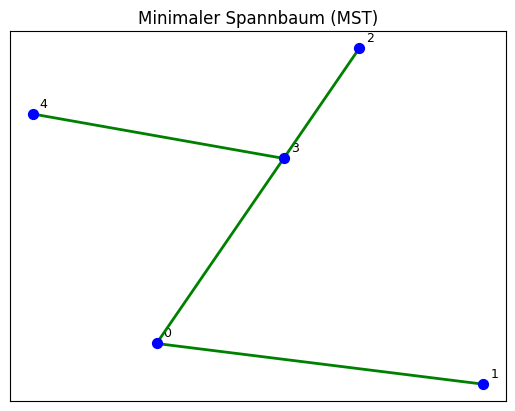

MST-Kanten (Indexpaare): [(0, 3), (3, 2), (3, 4), (0, 1)]


In [76]:
def plot_mst(mst_edges):
    """Visualisiert den minimalen Spannbaum (MST) im Vergleich zu den ursprünglichen Punkten.
    
    Parameter:
      mst_edges (list): Liste der MST-Kanten als Indexpaare (u, v).
    """
    plt.clf()
    # Erstelle einen Scatter-Plot für alle Punkte
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=5, s=50)
    
    # Beschrifte jeden Knoten mit seinem Index
    for i, (x, y) in enumerate(points):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Zeichne die MST-Kanten ein
    for u, v in mst_edges:
        plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 'g-', zorder=3, linewidth=2)
    
    plt.title("Minimaler Spannbaum (MST)")
    plt.grid(True, alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Berechne und visualisiere den MST für unsere Punktemenge
n = len(points)  # Anzahl der Punkte
mst_edges = compute_MST(n)
plot_mst(mst_edges)
print("MST-Kanten (Indexpaare):", mst_edges)

### 3. Identifikation von Knoten mit ungeradem Grad
Im nächsten Schritt müssen wir die Knoten finden, die im MST einen ungeraden Grad haben:

Der **Grad** eines Punktes ist die Anzahl der Verbindungen, die an diesem Punkt zusammenkommen. Wir suchen nach Punkten, bei denen eine ungerade Anzahl von Verbindungen zusammentrifft (1, 3, 5, usw.).

**Warum ist das wichtig?** Für den Eulerkreis, den wir später benötigen, müssen alle Punkte einen geraden Grad haben. Punkte mit ungeradem Grad bereiten Probleme, weil man beim Durchlaufen aller Verbindungen an ihnen "steckenbleiben" würde.

**Alltagsbeispiel**: Stellen Sie sich vor, jede Verbindung ist eine einbahnige Brücke. An einem Punkt mit ungeradem Grad würden Sie irgendwann feststecken, weil Sie eine Brücke zum Hineinkommen benutzt haben, aber keine mehr zum Herauskommen übrig ist.

In der unten stehenden Visualisierung werden Knoten mit ungeradem Grad rot hervorgehoben.

#### Mathematische Erklärung

Der Grad eines Knotens $v$ in einem Graphen $G$ ist die Anzahl der inzidenten Kanten an $v$, bezeichnet als $\text{deg}(v)$.

In einem Baum mit $n$ Knoten gibt es genau $n-1$ Kanten. Nach dem Handschlaglemma der Graphentheorie ist die Summe aller Knotengrade gleich dem Doppelten der Kantenanzahl:

$$ \sum_{v \in V} \text{deg}(v) = 2|E| = 2(n-1) $$

Daraus folgt, dass die Anzahl der Knoten mit ungeradem Grad in jedem Graphen gerade sein muss. In einem MST gibt es oft mehrere Knoten mit ungeradem Grad, und wir müssen diese identifizieren, um im nächsten Schritt ein perfektes Matching für sie zu finden.

Für jeden Knoten $v$ im MST berechnen wir:

$$ \text{deg}(v) = |\{u \in V : (u, v) \in T\}| $$

und sammeln diejenigen Knoten $v$, für die $\text{deg}(v) \mod 2 = 1$ gilt.

In [77]:
def get_odd_vertices(mst_edges, n):
    """Ermittelt die Knoten im MST mit ungeradem Grad.
    
    Parameter:
      mst_edges (list): Liste der Kanten im MST, jedes Element ist ein Tupel (u, v).
      n (int): Anzahl der Knoten.
    
    Rückgabe:
      list: Liste der Knotenindizes mit ungeradem Grad.
    """
    degree = [0] * n   # Array zur Speicherung der Gradanzahl für jeden Knoten.
    
    # Für jede Kante im MST erhöhen wir den Grad beider beteiligter Knoten.
    for u, v in mst_edges:
        degree[u] += 1
        degree[v] += 1
    
    # Erstelle eine Liste aller Knoten, deren Grad ungerade ist.
    odd_vertices = [i for i in range(n) if degree[i] % 2 == 1]
    return odd_vertices

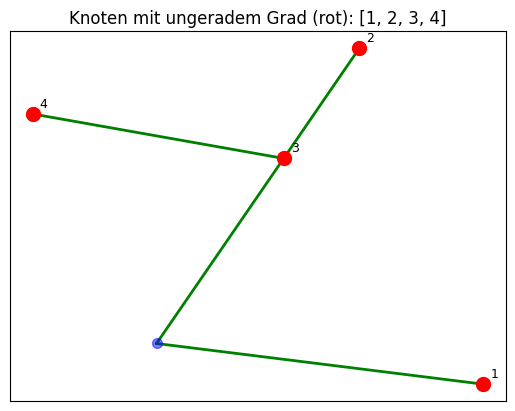

Knoten mit ungeradem Grad: [1, 2, 3, 4]


In [78]:
def plot_odd_vertices(mst_edges, odd_vertices):
    """Visualisiert den MST und hebt die Knoten mit ungeradem Grad hervor.
    
    Parameter:
      mst_edges (list): Liste der MST-Kanten als Indexpaare (u, v).
      odd_vertices (list): Liste der Knotenindizes mit ungeradem Grad.
    """
    plt.clf()
    # Erstelle einen Scatter-Plot für alle Punkte
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=3, s=50, alpha=0.5)
    
    # Zeichne die MST-Kanten ein
    for u, v in mst_edges:
        plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 'g-', zorder=2, linewidth=2)
    
    # Hebe die Knoten mit ungeradem Grad hervor
    for i in odd_vertices:
        plt.scatter(points[i][0], points[i][1], color='red', s=100, zorder=5)
        plt.annotate(str(i), (points[i][0], points[i][1]), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.title(f"Knoten mit ungeradem Grad (rot): {odd_vertices}")
    plt.grid(True, alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Finde und visualisiere die Knoten mit ungeradem Grad
odd_vertices = get_odd_vertices(mst_edges, n)
plot_odd_vertices(mst_edges, odd_vertices)
print("Knoten mit ungeradem Grad:", odd_vertices)

### 4. Minimales perfektes Matching der Knoten mit ungeradem Grad

#### 4.1 Theoretisches Konzept

Das **perfekte Matching** ist ein grundlegender Baustein des Christofides-Algorithmus:

- Ein **Matching** in einem Graphen ist eine Teilmenge der Kanten, sodass keine zwei Kanten einen gemeinsamen Endknoten haben
- Ein **perfektes Matching** ist ein Matching, bei dem jeder Knoten des Graphen von genau einer Kante des Matchings berührt wird
- Ein **minimales perfektes Matching** minimiert die Summe der Kantengewichte über alle möglichen perfekten Matchings

In unserem Fall suchen wir ein minimales perfektes Matching für die Menge der Knoten mit ungeradem Grad.

#### 4.2 Bedeutung für den Christofides-Algorithmus

Für den Erfolg des Algorithmus ist dieses Matching aus zwei Gründen entscheidend:

1. Das Matching verwandelt alle Knoten mit ungeradem Grad in solche mit geradem Grad, was die Existenz eines Eulerkreises garantiert
2. Die Minimalität des Matchings trägt zur Approximationsgarantie von 3/2 bei

#### 4.3 Implementierung

Für kleine Graphen können wir ein optimales Matching durch rekursives Backtracking finden. In der Praxis würde man für größere Graphen effizientere Algorithmen wie den "Blossom"-Algorithmus verwenden, der eine Laufzeit von O(n³) besitzt.

In [79]:
def min_weight_perfect_matching(odd_vertices):
    """Berechnet per rekursiver Backtracking-Suche das minimale perfekte Matching 
       der ungeraden Knoten.
    
    Parameter:
      odd_vertices (list): Liste der Knotenindizes mit ungeradem Grad.
    
    Rückgabe:
      list: Liste von Kanten (Tupel), die das Matching darstellen.
    """
    best_matching = None         # Variable zur Speicherung des besten Matching (mit minimalem Gesamtgewicht)
    best_weight = math.inf       # Initialisiere das beste Gewicht als unendlich
    
    # Rekursive Hilfsfunktion, um alle möglichen Matchings zu untersuchen
    def match_recursive(matching, unmatched, weight_so_far):
        nonlocal best_matching, best_weight
        
        # Basisfall: Wenn keine ungematchten Knoten mehr vorhanden sind,
        # prüfen wir das gefundene Matching
        if not unmatched:
            if weight_so_far < best_weight:
                best_weight = weight_so_far
                best_matching = matching.copy()  # Speichere das aktuelle Matching als bestes gefundenes
            return
        
        # Wähle den ersten ungematchten Knoten
        i = unmatched[0]
        
        # Versuche, i mit jedem der verbleibenden ungematchten Knoten zu matchen
        for j in unmatched[1:]:
            # Berechne die Distanz zwischen Knoten i und j als Gewicht des Paares
            pair_weight = euclidean(i, j)
            
            # Erstelle eine Kopie der Liste der ungematchten Knoten und entferne i und j daraus
            new_unmatched = unmatched.copy()
            new_unmatched.remove(i)
            new_unmatched.remove(j)
            
            # Führe die rekursive Suche fort, indem das aktuelle Paar zum Matching hinzugefügt wird
            match_recursive(matching + [(i, j)], new_unmatched, weight_so_far + pair_weight)
    
    # Starte die rekursive Suche mit einem leeren Matching, allen ungematchten Knoten und null anfänglichem Gewicht
    match_recursive([], odd_vertices, 0)
    return best_matching

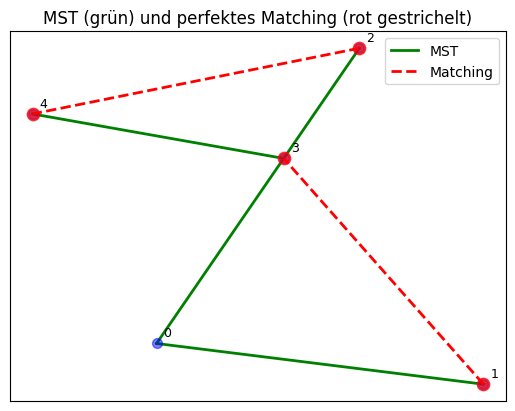

Perfektes Matching der Knoten mit ungeradem Grad: [(1, 3), (2, 4)]


In [80]:
def plot_matching(mst_edges, odd_vertices, matching):
    """Visualisiert den MST und das gefundene perfekte Matching.
    
    Parameter:
      mst_edges (list): Liste der MST-Kanten als Indexpaare (u, v).
      odd_vertices (list): Liste der Knotenindizes mit ungeradem Grad.
      matching (list): Liste der Matchingkanten als Indexpaare (u, v).
    """
    plt.clf()
    
    # Erstelle einen Scatter-Plot für alle Punkte
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=3, s=50, alpha=0.5)
    
    # Beschrifte jeden Knoten mit seinem Index
    for i, (x, y) in enumerate(points):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Zeichne die MST-Kanten ein
    for u, v in mst_edges:
        plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 'g-', zorder=2, linewidth=2, 
                 label="MST" if u == mst_edges[0][0] and v == mst_edges[0][1] else "")
    
    # Zeichne die Matching-Kanten ein
    for u, v in matching:
        plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 'r--', zorder=4, linewidth=2, 
                 label="Matching" if u == matching[0][0] and v == matching[0][1] else "")
    
    # Hebe die Knoten mit ungeradem Grad hervor
    for i in odd_vertices:
        plt.scatter(points[i][0], points[i][1], color='red', s=80, zorder=5, alpha=0.7)
    
    plt.title("MST (grün) und perfektes Matching (rot gestrichelt)")
    plt.grid(True, alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.show()

# Berechne und visualisiere das perfekte Matching
matching = min_weight_perfect_matching(odd_vertices)
plot_matching(mst_edges, odd_vertices, matching)
print("Perfektes Matching der Knoten mit ungeradem Grad:", matching)

### 5. Erstellung eines Multigraphen

#### 5.1 Konzept des Multigraphen

Nachdem wir den MST und das minimale perfekte Matching berechnet haben, kombinieren wir diese zu einem **Multigraphen**:

- Ein **Multigraph** erlaubt mehrere Kanten zwischen denselben Knoten
- Wir vereinigen die Kantenmenge des MST mit der Kantenmenge des Matchings
- Dadurch haben nun alle Knoten einen **geraden Grad**

#### 5.2 Mathematischer Hintergrund

Die Konstruktion des Multigraphen basiert auf folgender Eigenschaft:

- Im MST hatten nur bestimmte Knoten ungeraden Grad
- Das Hinzufügen einer Matching-Kante erhöht den Grad eines Knotens um 1
- Da alle Knoten mit ungeradem Grad im perfekten Matching verbunden werden, erhöht sich ihr Grad jeweils um 1
- ungerade + 1 = gerade, somit haben nun alle Knoten einen geraden Grad

Nach Eulers Theorem enthält ein Graph genau dann einen **Eulerkreis**, wenn alle Knoten geraden Grad haben und der Graph zusammenhängend ist. Beide Bedingungen sind nun erfüllt.

In [81]:
def create_multigraph(n, mst_edges, matching):
    """Erstellt aus den MST-Kanten und dem Matching einen Multigraphen als Nachbarschaftsliste.
    
    Parameter:
      n (int): Anzahl der Knoten.
      mst_edges (list): Kanten des MST.
      matching (list): Kanten des perfekten Matchings.
    
    Rückgabe:
      dict: Dictionary, wobei jeder Schlüssel (Knotenindex) eine Liste von benachbarten Knoten hat.
    """
    # Initialisiere den Graphen als Dictionary mit leeren Nachbarschaftslisten
    graph = {i: [] for i in range(n)}
    
    # Füge alle MST-Kanten hinzu (in beide Richtungen, da ungerichtet)
    for u, v in mst_edges:
        graph[u].append(v)
        graph[v].append(u)
    
    # Füge alle Matching-Kanten hinzu (ebenfalls in beide Richtungen)
    for u, v in matching:
        graph[u].append(v)
        graph[v].append(u)
        
    return graph

In [82]:
def plot_multigraph(mst_edges, matching):
    """Visualisiert den Multigraphen, bestehend aus MST-Kanten und Matching-Kanten.
    
    Parameter:
      mst_edges (list): Liste der MST-Kanten als Indexpaare (u, v).
      matching (list): Liste der Matchingkanten als Indexpaare (u, v).
    """
    plt.clf()
    
    # Erstelle einen Scatter-Plot für alle Punkte
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=5, s=60)
    
    # Beschrifte jeden Knoten mit seinem Index
    for i, (x, y) in enumerate(points):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Zeichne die MST-Kanten ein
    for u, v in mst_edges:
        plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 'g-', zorder=2, linewidth=2, 
                 label="MST" if u == mst_edges[0][0] and v == mst_edges[0][1] else "")
    
    # Zeichne die Matching-Kanten ein
    if matching:
        for u, v in matching:
            plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 'r--', zorder=3, linewidth=2, 
                     label="Matching" if u == matching[0][0] and v == matching[0][1] else "")
    
    plt.title("Multigraph (MST + Matching)")
    plt.grid(True, alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.show()

# Erstelle und visualisiere den Multigraphen
multigraph = create_multigraph(n, mst_edges, matching)
# plot_multigraph(mst_edges, matching)

print("Multigraph als Nachbarschaftsliste:")
for node, neighbors in multigraph.items():
    print(f"Knoten {node}: {neighbors}")

Multigraph als Nachbarschaftsliste:
Knoten 0: [3, 1]
Knoten 1: [0, 3]
Knoten 2: [3, 4]
Knoten 3: [0, 2, 4, 1]
Knoten 4: [3, 2]


### 6. Berechnung eines Eulerkreises

#### 6.1 Definition und Bedeutung

Ein **Eulerkreis** ist ein geschlossener Rundweg, der jede **Kante** des Graphen genau einmal durchläuft. Die Existenz eines Eulerkreises ist durch die Konstruktion unseres Multigraphen garantiert, da alle Knoten geraden Grad haben.

#### 6.2 Hierholzer-Algorithmus

Der **Hierholzer-Algorithmus** ist ein effizienter Algorithmus zur Berechnung eines Eulerkreises:

1. Beginne mit einem beliebigen Knoten und folge einem Pfad, wobei jede benutzte Kante gelöscht wird
2. Fahre fort, bis ein geschlossener Rundweg entsteht (Kreislauf)
3. Solange der Kreislauf noch nicht alle Kanten enthält:
   - Wähle einen Knoten des Kreislaufs, der noch ausgehende Kanten hat
   - Erzeuge von diesem Knoten aus einen neuen Kreislauf
   - Verschmelze diesen neuen Kreislauf mit dem bestehenden

#### 6.3 Theoretische Analyse

- **Korrektheit**: Der Algorithmus findet garantiert einen Eulerkreis, wenn alle Knoten geraden Grad haben
- **Zeitkomplexität**: O(|E|), wobei |E| die Anzahl der Kanten ist
- **Speicherkomplexität**: O(|E|) zur Speicherung des Graphen und des Eulerkreises

In [83]:
def find_eulerian_tour(graph):
    """Findet mit Hierholzer-Algorithmus einen eulerischen Rundgang im gegebenen Graphen.
    
    Parameter:
      graph (dict): Nachbarschaftsliste des Graphen.
    
    Rückgabe:
      list: Liste der Knoten, die den eulerischen Rundgang in der berechneten Reihenfolge darstellen.
    """
    # Erstelle eine Kopie des Graphen, um die Originalstruktur nicht zu verändern
    graph_copy = {u: graph[u].copy() for u in graph}
    tour = []    # Liste zum Speichern des Eulerkreises
    stack = [0]  # Startpunkt des Rundgangs ist Knoten 0
    
    # Solange es noch Knoten im Stack gibt, wird der Algorithmus fortgesetzt
    while stack:
        u = stack[-1]  # Aktueller Knoten ist der oberste auf dem Stack
        
        if graph_copy[u]:  # Wenn der Knoten noch unbesuchte Nachbarn hat
            # Wähle einen Nachbarn und "besuche" diese Kante
            v = graph_copy[u].pop()
            stack.append(v)          
            
            # Entferne die Rückkante (v, u) aus dem Graphen (ungerichteter Graph)
            graph_copy[v].remove(u)
        else:
            # Wenn keine unbesuchten Kanten mehr vorhanden sind, füge den Knoten dem Eulerkreis hinzu
            tour.append(stack.pop())
    
    # Die Rückgabe erfolgt in der korrekten Reihenfolge des Rundgangs
    return tour[::-1]

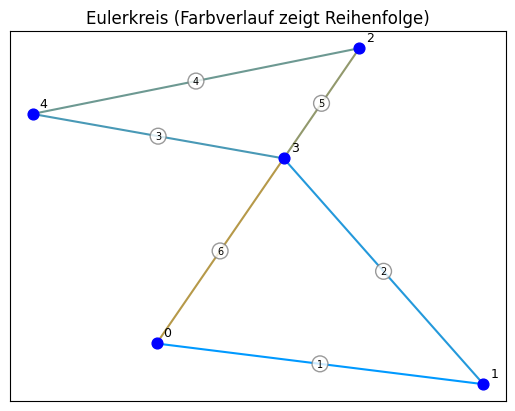

Eulerkreis (Knotenindizes): [0, 1, 3, 4, 2, 3, 0]
Länge des Eulerkreises: 7


In [84]:
def plot_eulerian_tour(eulerian_tour):
    """Visualisiert den gefundenen Eulerkreis.
    
    Parameter:
      eulerian_tour (list): Liste der Knoten des Eulerkreises.
    """
    plt.clf()
    
    # Erstelle einen Scatter-Plot für alle Punkte
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=5, s=60)
    
    # Beschrifte jeden Knoten mit seinem Index
    for i, (x, y) in enumerate(points):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Zeichne den Eulerkreis mit Farbverlauf (früher = grün, später = rot)
    for i in range(len(eulerian_tour)-1):
        u = eulerian_tour[i]
        v = eulerian_tour[i+1]
        
        # Berechne Position der Knoten im Rundweg für die Farbgebung
        pos = i / len(eulerian_tour)
        color = (pos, 0.6, 1-pos)  # RGB-Farbverlauf von Grün nach Rot
        
        plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 
                 color=color, zorder=2, linewidth=1.5)
        
        # Markiere die Reihenfolge der Kanten im Eulerkreis
        mid_x = (points[u][0] + points[v][0]) / 2
        mid_y = (points[u][1] + points[v][1]) / 2
        plt.annotate(str(i+1), (mid_x, mid_y), fontsize=7, ha='center', va='center',
                     bbox=dict(boxstyle="circle", fc="white", ec="gray", alpha=0.8))
    
    plt.title("Eulerkreis (Farbverlauf zeigt Reihenfolge)")
    plt.grid(True, alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Berechne und visualisiere den Eulerkreis
eulerian_tour = find_eulerian_tour(multigraph)
plot_eulerian_tour(eulerian_tour)
print("Eulerkreis (Knotenindizes):", eulerian_tour)
print("Länge des Eulerkreises:", len(eulerian_tour))

### 7. Umwandlung des Eulerkreises in einen Hamiltonkreis

#### 7.1 Vom Eulerkreis zum Hamiltonkreis

Der gefundene **Eulerkreis** besucht jede **Kante** genau einmal, kann dabei aber **Knoten** mehrfach besuchen. Für unsere TSP-Lösung benötigen wir einen **Hamiltonkreis**, der jeden Knoten genau einmal besucht.

Die Umwandlung erfolgt durch das sogenannte **Shortcutting**:

1. Wir durchlaufen den Eulerkreis in der berechneten Reihenfolge
2. Wir nehmen einen Knoten in unseren Hamiltonkreis auf, wenn wir ihn zum ersten Mal besuchen
3. Alle weiteren Besuche desselben Knotens werden übersprungen

#### 7.2 Theoretische Analyse

- **Dreiecksungleichung**: Da die euklidische Distanz die Dreiecksungleichung erfüllt, kann das Überspringen von Knoten die Gesamtlänge nur verkürzen
- **Approximationsfaktor**: Der durch Shortcutting erzeugte Hamiltonkreis hat höchstens die gleiche Länge wie der Eulerkreis
- **Folgerung**: Da der Eulerkreis höchstens 3/2 mal so lang wie die optimale Lösung ist, gilt dies auch für den resultierenden Hamiltonkreis

Diese theoretische Garantie macht den Christofides-Algorithmus besonders wertvoll für praktische Anwendungen.

In [85]:
def shortcut_eulerian(tour):
    """Umwandlung eines eulerischen Rundgangs in einen Hamiltonkreis durch Überspringen wiederholter Knoten.
    
    Parameter:
      tour (list): Liste der Knoten des Eulerkreises.
    
    Rückgabe:
      list: Liste der Knoten des resultierenden Hamiltonkreises.
    """
    visited = set()  # Set zur Speicherung bereits besuchter Knoten
    path = []        # Liste zur Speicherung des Hamiltonkreises
    
    # Gehe die Reihenfolge der Knoten im Eulerkreis durch
    for vertex in tour:
        # Nur Knoten hinzufügen, die noch nicht besucht wurden
        if vertex not in visited:
            visited.add(vertex)
            path.append(vertex)
    
    # Schließe den Kreis, indem der Startknoten wieder angehängt wird
    path.append(path[0])
    return path

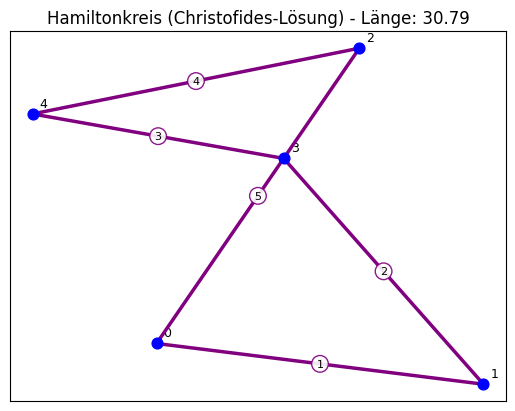

Hamiltonkreis (Knotenindizes): [0, 1, 3, 4, 2, 0]
Anzahl der Knoten im Hamiltonkreis: 6


In [86]:
def plot_hamiltonian(hamiltonian):
    """Visualisiert den resultierenden Hamiltonkreis.
    
    Parameter:
      hamiltonian (list): Liste der Knoten des Hamiltonkreises.
    """
    plt.clf()
    
    # Erstelle einen Scatter-Plot für alle Punkte
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=5, s=60)
    
    # Beschrifte jeden Knoten mit seinem Index
    for i, (x, y) in enumerate(points):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Zeichne den Hamiltonkreis
    for i in range(len(hamiltonian)-1):
        u = hamiltonian[i]
        v = hamiltonian[i+1]
        plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 'purple', zorder=3, linewidth=2.5)
        
        # Markiere die Reihenfolge der Kanten
        mid_x = (points[u][0] + points[v][0]) / 2
        mid_y = (points[u][1] + points[v][1]) / 2
        plt.annotate(str(i+1), (mid_x, mid_y), fontsize=8, ha='center', va='center',
                     bbox=dict(boxstyle="circle", fc="white", ec="purple", alpha=0.9))
    
    # Berechne die Gesamtlänge der Route
    hamilton_points = [points[i] for i in hamiltonian]
    total_distance = sum(math.dist(hamilton_points[i], hamilton_points[i+1]) for i in range(len(hamilton_points)-1))
    
    plt.title(f"Hamiltonkreis (Christofides-Lösung) - Länge: {total_distance:.2f}")
    plt.grid(True, alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.savefig("christofides.png", dpi=300, format="png", bbox_inches="tight")
    plt.show()

# Berechne und visualisiere den Hamiltonkreis
hamiltonian = shortcut_eulerian(eulerian_tour)
plot_hamiltonian(hamiltonian)
print("Hamiltonkreis (Knotenindizes):", hamiltonian)
print("Anzahl der Knoten im Hamiltonkreis:", len(hamiltonian))

## 8. Vergleich und Bewertung der Algorithmen

### 8.1 Theoretische Bewertung

In diesem Abschnitt vergleichen wir die drei vorgestellten Algorithmen hinsichtlich ihrer theoretischen Eigenschaften:

| Algorithmus | Zeitkomplexität | Approximationsgarantie | Praktische Anwendbarkeit |
|-------------|-----------------|------------------------|--------------------------|
| Brute-Force | $O(n!)$ | Optimal (Faktor 1.0) | Nur für sehr kleine Instanzen ($n \leq 12$) |
| Nearest-Neighbor | $O(n^2)$ | Keine Garantie, im schlimmsten Fall $\Theta(\log n)$ | Für große Instanzen, wenn Geschwindigkeit wichtiger ist als Qualität |
| Christofides | $O(n^3)$ | Faktor 3/2 (1.5) | Für mittelgroße bis große Instanzen mit gutem Kompromiss aus Qualität und Geschwindigkeit |

### 8.2 Christofides-Implementierung

Für eine vollständige Implementierung des Christofides-Algorithmus fassen wir die einzelnen Schritte zusammen:

In [87]:
def christofides_route():
    """Implementiert den vollständigen Christofides-Algorithmus und gibt die berechnete Route zurück."""
    
    global christofides_operations
    christofides_operations = 0  # Zurücksetzen des Zählers
    
    # Startzeit messen
    start_time = time.time()
    
    # Schritt 1: MST berechnen
    n = len(points)
    mst_edges = compute_MST(n)
    
    # Schritt 2: Knoten mit ungeradem Grad identifizieren
    odd_vertices = get_odd_vertices(mst_edges, n)
    
    # Schritt 3: Minimales perfektes Matching der ungeraden Knoten
    matching = min_weight_perfect_matching(odd_vertices)
    
    # Schritt 4: Multigraph erstellen
    multigraph = create_multigraph(n, mst_edges, matching)
    
    # Schritt 5: Eulerkreis finden
    eulerian_tour = find_eulerian_tour(multigraph)
    
    # Schritt 6: Hamiltonkreis ableiten
    hamiltonian = shortcut_eulerian(eulerian_tour)
    
    # Berechne die Koordinaten der Route und die Gesamtdistanz
    route_coords = [points[i] for i in hamiltonian]
    total_distance = sum(math.dist(route_coords[i], route_coords[i+1]) 
                        for i in range(len(route_coords)-1))
    
    # Endzeit messen
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Speichere Ergebnisse
    algorithm_results['christofides']['distance'] = total_distance
    algorithm_results['christofides']['time'] = execution_time
    algorithm_results['christofides']['operations'] = christofides_operations
    
    print(f"Christofides-Algorithmus - Route-Länge: {total_distance:.2f}")
    print(f"Berechnungszeit: {execution_time:.6f} Sekunden")
    print(f"Anzahl der Distanzberechnungen: {christofides_operations}")
    
    return route_coords, total_distance

# Führe den Christofides-Algorithmus aus
christofides_route_coords, christofides_distance = christofides_route()

Christofides-Algorithmus - Route-Länge: 30.79
Berechnungszeit: 0.000000 Sekunden
Anzahl der Distanzberechnungen: 16


### 8.3 Empirischer Vergleich der Algorithmen

Nach der theoretischen Analyse betrachten wir nun die empirischen Resultate der drei Algorithmen auf unserer Testinstanz:

In [88]:
# Visualisiere die Ergebnisse in tabellarischer Form
%pip install pandas -q

import pandas as pd
from IPython.display import display, HTML

# Erstelle eine Vergleichstabelle
data = {
    'Algorithmus': ['Brute Force', 'Nearest Neighbor', 'Christofides'],
    'Distanz': [algorithm_results['brute_force']['distance'], 
               algorithm_results['nearest_neighbor']['distance'],
               algorithm_results['christofides']['distance']],
    'Laufzeit (s)': [algorithm_results['brute_force']['time'],
                    algorithm_results['nearest_neighbor']['time'],
                    algorithm_results['christofides']['time']],
    'Operationen': [algorithm_results['brute_force']['operations'],
                   algorithm_results['nearest_neighbor']['operations'],
                   algorithm_results['christofides']['operations']],
    'Approximationsfaktor': [1.0, 
                            algorithm_results['nearest_neighbor']['distance'] / algorithm_results['brute_force']['distance'],
                            algorithm_results['christofides']['distance'] / algorithm_results['brute_force']['distance']]
}

df = pd.DataFrame(data)

# Formatiere die Tabelle für eine bessere Darstellung
df['Distanz'] = df['Distanz'].apply(lambda x: f"{x:.2f}")
df['Laufzeit (s)'] = df['Laufzeit (s)'].apply(lambda x: f"{x:.6f}")
df['Approximationsfaktor'] = df['Approximationsfaktor'].apply(lambda x: f"{x:.2f}")

# Setze HTML-Styling für die Tabelle
styled_df = df.style.set_properties(**{'text-align': 'center'})
styled_df = styled_df.set_caption("Vergleich der Algorithmen für das Traveling Salesman Problem")
styled_df = styled_df.hide(axis='index')  # Updated from hide_index() for newer pandas versions

display(styled_df)

Note: you may need to restart the kernel to use updated packages.


Algorithmus,Distanz,Laufzeit (s),Operationen,Approximationsfaktor
Brute Force,27.19,0.000000,120,1.00
Nearest Neighbor,30.03,0.000000,10,1.10
Christofides,30.79,0.000000,16,1.13


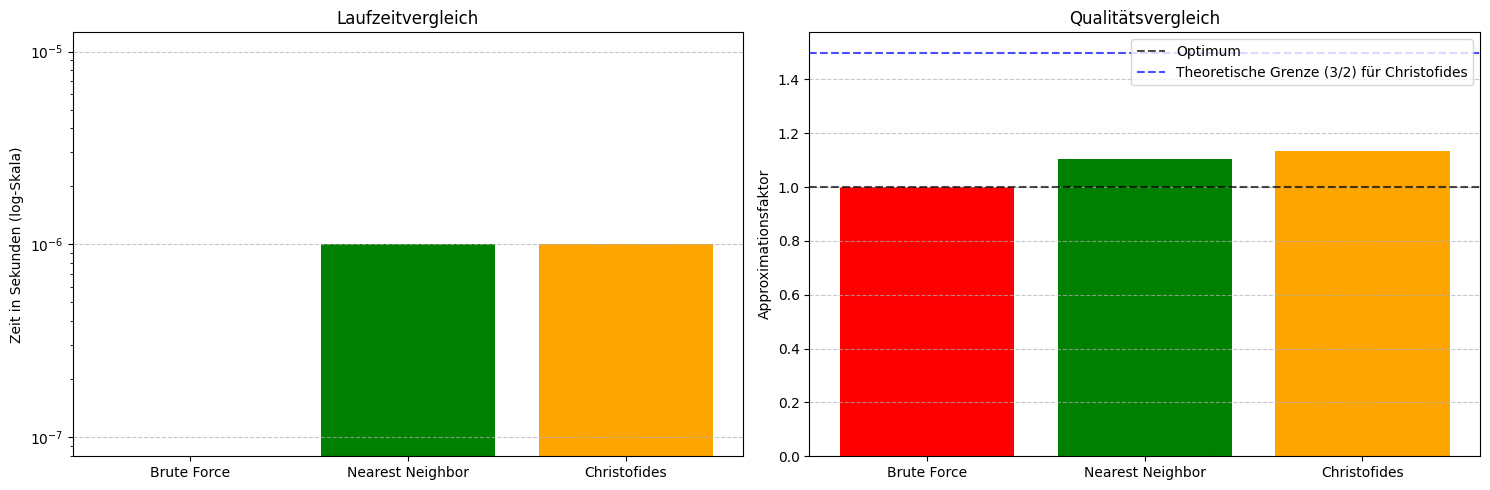

In [89]:
# Visualisiere den Vergleich der Laufzeiten und Approximationsfaktoren
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Laufzeit-Vergleich (logarithmische Skala)
ax[0].bar(['Brute Force', 'Nearest Neighbor', 'Christofides'], 
         [algorithm_results['brute_force']['time'], 
          max(algorithm_results['nearest_neighbor']['time'], 0.000001),
          max(algorithm_results['christofides']['time'], 0.000001)],
         color=['red', 'green', 'orange'])
ax[0].set_ylabel('Zeit in Sekunden (log-Skala)')
ax[0].set_title('Laufzeitvergleich')
ax[0].set_yscale('log')
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Approximationsfaktor-Vergleich
ax[1].bar(['Brute Force', 'Nearest Neighbor', 'Christofides'], 
         [1.0, 
          algorithm_results['nearest_neighbor']['distance'] / algorithm_results['brute_force']['distance'],
          algorithm_results['christofides']['distance'] / algorithm_results['brute_force']['distance']],
         color=['red', 'green', 'orange'])
ax[1].set_ylabel('Approximationsfaktor')
ax[1].set_title('Qualitätsvergleich')
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].axhline(y=1.0, color='black', linestyle='--', alpha=0.7, label='Optimum')
ax[1].axhline(y=1.5, color='blue', linestyle='--', alpha=0.7, label='Theoretische Grenze (3/2) für Christofides')
ax[1].legend()

plt.tight_layout()
plt.show()


Der Approximationsfaktor ergibt sich aus dem Verhältnis:
   
• Approximationsfaktor = (Distanz der gefundenen Route) / (optimal mögliche Distanz)

Brute-Force liefert die exakte Lösung (Faktor = 1).  
Nearest-Neighbor und Christofides werden daran gemessen, wieviel länger ihre berechneten Routen im Vergleich zur optimalen Route sind. Insbesondere zeigt sich mathematisch, dass Christofides dank MST + perfektem Matching + Dreiecksungleichung stets höchstens 1,5-fach von der Optimaldistanz abweicht.


### 8.4 Schlussfolgerungen

Aus unseren theoretischen Überlegungen und empirischen Tests können wir folgende Schlüsse ziehen:

1. **Brute-Force-Algorithmus**:
   - **Vorteile**: Garantiert die optimale Lösung
   - **Nachteile**: Exponentiell steigende Laufzeit, praktisch unmöglich für mehr als ca. 12 Punkte
   - **Anwendungsgebiet**: Kleine TSP-Instanzen, bei denen Optimalität zwingend erforderlich ist

2. **Nearest-Neighbor-Algorithmus**:
   - **Vorteile**: Sehr schnell, einfach zu implementieren, skaliert gut
   - **Nachteile**: Keine Qualitätsgarantie, kann in speziellen Fällen sehr schlechte Lösungen liefern
   - **Anwendungsgebiet**: Echtzeitanwendungen oder sehr große TSP-Instanzen, bei denen Geschwindigkeit wichtiger ist als Qualität

3. **Christofides-Algorithmus**:
   - **Vorteile**: Garantierte Qualitätsgrenze (max. 50% vom Optimum entfernt), in der Praxis oft nahe am Optimum
   - **Nachteile**: Komplexere Implementierung, langsamer als Nearest-Neighbor
   - **Anwendungsgebiet**: Anwendungen, die einen guten Kompromiss zwischen Qualität und Laufzeit benötigen

Diese Algorithmen repräsentieren wichtige Klassen von Lösungsansätzen für NP-schwere Probleme:
- Exakte Algorithmen (Brute-Force) → garantiert optimal, aber oft praktisch nicht anwendbar
- Einfache Heuristiken (Nearest-Neighbor) → schnell, aber ohne Qualitätsgarantie
- Approximationsalgorithmen (Christofides) → mit bewiesener Gütegarantie

In der Praxis werden oft noch fortgeschrittenere Methoden wie lokale Suchverfahren, genetische Algorithmen oder Branch-and-Bound-Verfahren eingesetzt, um auch große TSP-Instanzen effizient zu lösen.

## 9. Demonstration mit größeren Datenmengen

Um die Skalierbarkeit der Algorithmen zu demonstrieren, betrachten wir eine größere Instanz mit 30 Punkten. Bei dieser Größe ist der Brute-Force-Algorithmus bereits vollkommen unpraktikabel, da er ca. $30! \approx 2.65 \cdot 10^{32}$ Permutationen überprüfen müsste.

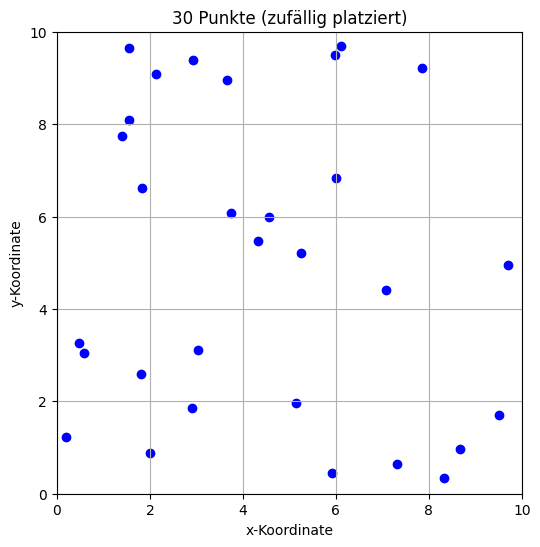

Berechne Nearest Neighbor Route...
Berechne Christofides Route...
Christofides-Algorithmus - Route-Länge: 47.21
Berechnungszeit: 0.001999 Sekunden
Anzahl der Distanzberechnungen: 2712


In [90]:
# Erzeuge eine größere Punktemenge mit 30 Punkten
np.random.seed(42)  # Für reproduzierbare Ergebnisse
number_of_points_large = 30
x_large = np.random.rand(number_of_points_large) * 10
y_large = np.random.rand(number_of_points_large) * 10
points_large = list(zip(x_large, y_large))

# Erstelle eine Grafik und plotte die Punkte
plt.figure(figsize=(6, 6))
plt.scatter(x_large, y_large, color='blue')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.grid(True)
plt.title(f'{number_of_points_large} Punkte (zufällig platziert)')
plt.xlabel('x-Koordinate')
plt.ylabel('y-Koordinate')
plt.show()

# Backup der ursprünglichen Punkteliste
original_points = points.copy()

# Ersetze die Punkteliste temporär mit der größeren Menge
points = points_large

# Führe die Nearest-Neighbor und Christofides-Algorithmen aus
print("Berechne Nearest Neighbor Route...")
start_time_nn = time.time()
nn_route_large, operation_count_nn_large = nearest_neighbor(points_large)
end_time_nn = time.time()
execution_time_nn_large = end_time_nn - start_time_nn
nn_distance_large = route_distance(nn_route_large)

print("Berechne Christofides Route...")
christofides_operations = 0  # Zurücksetzen des Zählers
start_time_chr = time.time()
christofides_route_coords_large, christofides_distance_large = christofides_route()
end_time_chr = time.time()
execution_time_chr_large = end_time_chr - start_time_chr

# Setze die ursprüngliche Punkteliste wieder zurück
points = original_points

Algorithmus,Distanz,Laufzeit (s),Operationen
Nearest Neighbor,54.84,0.000000,435
Christofides,47.21,0.001999,2712


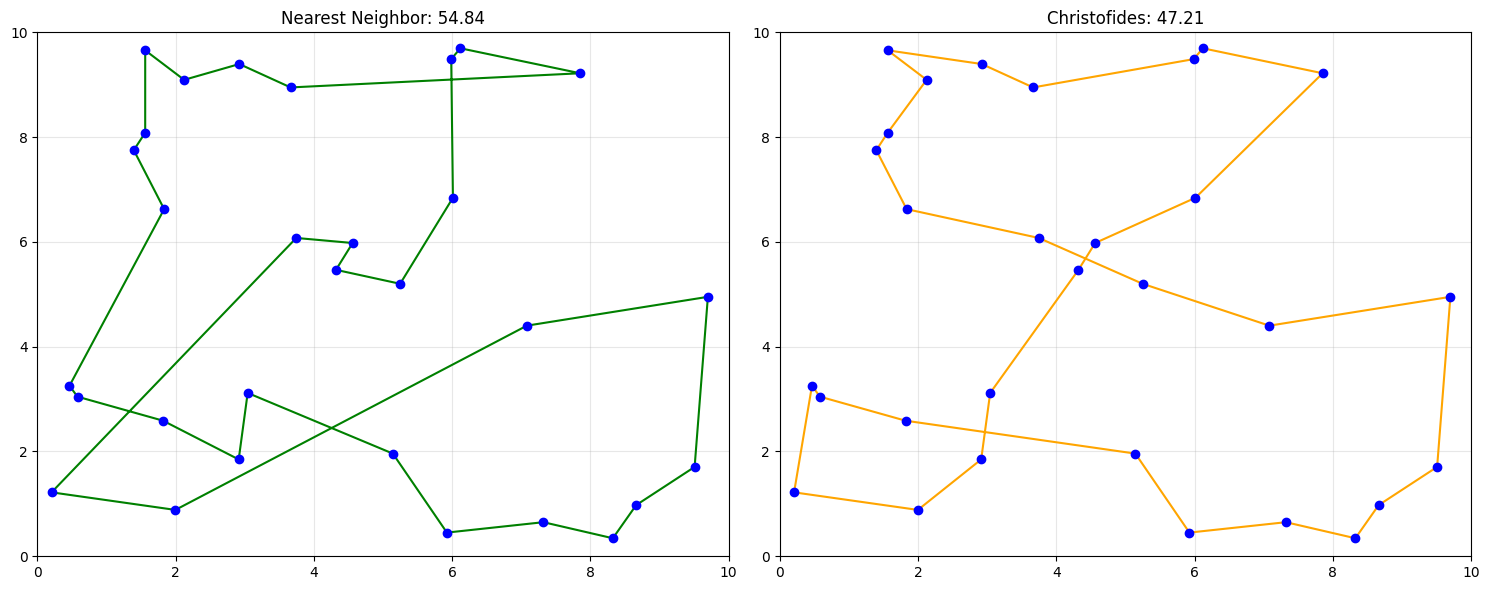

In [91]:
# Erstelle eine Vergleichstabelle für die größere Punktemenge
data_large = {
    'Algorithmus': ['Nearest Neighbor', 'Christofides'],
    'Distanz': [nn_distance_large, christofides_distance_large],
    'Laufzeit (s)': [execution_time_nn_large, execution_time_chr_large],
    'Operationen': [operation_count_nn_large, christofides_operations]
}

df_large = pd.DataFrame(data_large)

# Formatiere die Tabelle
df_large['Distanz'] = df_large['Distanz'].apply(lambda x: f"{x:.2f}")
df_large['Laufzeit (s)'] = df_large['Laufzeit (s)'].apply(lambda x: f"{x:.6f}")

# Setze HTML-Styling für die Tabelle
styled_df_large = df_large.style.set_properties(**{'text-align': 'center'})
styled_df_large = styled_df_large.set_caption(f"Vergleich der Algorithmen für {number_of_points_large} Punkte")
styled_df_large = styled_df_large.hide(axis='index')

display(styled_df_large)

# Visualisiere die Routen für beide Algorithmen
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Nearest Neighbor Route
ax[0].scatter(x_large, y_large, color='blue', zorder=5)
xs_nn = [p[0] for p in nn_route_large] + [nn_route_large[0][0]]
ys_nn = [p[1] for p in nn_route_large] + [nn_route_large[0][1]]
ax[0].plot(xs_nn, ys_nn, color='green', linewidth=1.5, marker='o', markersize=4)
ax[0].set_title(f"Nearest Neighbor: {nn_distance_large:.2f}")
ax[0].grid(True, alpha=0.3)
ax[0].set_xlim(0, 10)
ax[0].set_ylim(0, 10)

# Christofides Route
ax[1].scatter(x_large, y_large, color='blue', zorder=5)
xs_chr = [p[0] for p in christofides_route_coords_large]
ys_chr = [p[1] for p in christofides_route_coords_large]
ax[1].plot(xs_chr, ys_chr, color='orange', linewidth=1.5, marker='o', markersize=4)
ax[1].set_title(f"Christofides: {christofides_distance_large:.2f}")
ax[1].grid(True, alpha=0.3)
ax[1].set_xlim(0, 10)
ax[1].set_ylim(0, 10)

plt.tight_layout()
plt.show()

## 10. Zusammenfassung 

In dieser Vorlesung haben wir das Traveling Salesman Problem (TSP) als fundamentales Optimierungsproblem kennengelernt und drei verschiedene algorithmische Lösungsansätze im Detail untersucht:

1. Der **Brute-Force-Algorithmus** ist konzeptionell einfach, liefert optimale Lösungen, ist aber aufgrund seiner faktoriellen Laufzeit nur für sehr kleine Instanzen praktikabel.

2. Die **Nearest-Neighbor-Heuristik** bietet einen einfachen greedy Ansatz mit quadratischer Laufzeit, liefert jedoch keine Qualitätsgarantien.

3. Der **Christofides-Algorithmus** kombiniert MST und perfektes Matching zu einem Approximationsalgorithmus mit garantierter Qualitätsschranke von 3/2 des Optimums.

Unsere experimentellen Ergebnisse haben die theoretischen Eigenschaften dieser Algorithmen bestätigt: Der Brute-Force-Algorithmus liefert die optimale Lösung, während der Christofides-Algorithmus in der Praxis sehr nahe am Optimum liegt und der Nearest-Neighbor-Algorithmus zwar schnell ist, aber qualitativ schlechter abschneidet.


---



## Übung: Eigenen Algorithmus implementieren und vergleichen

1. Implementieren Sie einen zusätzlichen TSP-Algorithmus Ihrer Wahl (z.B. ein einfaches Zufallsverfahren oder eine anspruchsvollere Heuristik) in einer neuen Code-Zelle. Achten Sie darauf, bereits definierte Variablen nicht zu überschreiben.

2. Wenden Sie Ihren Algorithmus auf die gleiche Punktemenge an und messen Sie:
    - Gesamtdistanz der gefundenen Route  
    - Berechnungszeit  
    - Anzahl berechneter Operationen (wenn sinnvoll)  

3. Erstellen Sie anschließend eine Vergleichstabelle analog zum Beispiel unten und fügen Sie Ihre Resultate als neue Zeile hinzu:

```python
data_large = {
     'Algorithmus': ['Nearest Neighbor', 'Christofides', 'Mein Algorithmus'],
     'Distanz': [nn_distance_large, christofides_distance_large, meine_distanz],
     'Laufzeit (s)': [execution_time_nn_large, execution_time_chr_large, meine_zeit],
     'Operationen': [operation_count_nn_large, christofides_operations, meine_operationen]
}

df_large = pd.DataFrame(data_large)
df_large['Distanz'] = df_large['Distanz'].apply(lambda x: f"{x:.2f}")
df_large['Laufzeit (s)'] = df_large['Laufzeit (s)'].apply(lambda x: f"{x:.6f}")
styled_df_large = df_large.style.set_properties(**{'text-align': 'center'})
styled_df_large = styled_df_large.set_caption(f"Vergleich der Algorithmen für {number_of_points_large} Punkte")
styled_df_large = styled_df_large.hide(axis='index')
display(styled_df_large)
```

4. Visualisieren Sie auch die Route Ihres Algorithmus neben den bestehenden Lösungsansätzen, um die Unterschiede anschaulich zu machen. Nutzen Sie dafür das gleiche Plot-Schema wie bei Nearest Neighbor und Christofides.

## Übung: Eigenen Algorithmus implementieren und vergleichen

1. Implementieren Sie in einer neuen Code-Zelle einen zusätzlichen TSP-Algorithmus Ihrer Wahl (z.B. eine Zufallsheuristik oder ein lokales Suchverfahren). Achten Sie darauf, bereits definierte Variablen nicht zu überschreiben.  

2. Berechnen Sie mit Ihrem Algorithmus:
    - Gesamtdistanz der gefundenen Route  
    - Laufzeit (s)  
    - Anzahl berechneter Operationen (falls relevant)  

3. Erweitern Sie die bestehende Vergleichstabelle um eine weitere Zeile, in der Sie die Ergebnisse Ihres Algorithmus wie im Beispiel eintragen:
    - Listen Sie Algorithmus, Distanz, Laufzeit und Operationen auf.  

4. Plotten Sie die Route Ihres Algorithmus neben den bereits existierenden Routen, um einen direkten Vergleich zu ermöglichen. Nutzen Sie dafür den gleichen Aufbau der Visualisierung (Punkte in Blau, Pfad als Linienzug, Achseneinstellungen, etc.).  

5. Diskutieren Sie abschließend, wo Ihr Algorithmus Ergebnisse liefert, die besser oder schlechter sind als die der bestehenden Verfahren, und überlegen Sie mögliche Verbesserungsansätze.
